In [914]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time, re
import statsmodels.api as sm
import pptx
from pptx.util import Inches, Pt
from matplotlib.ticker import MultipleLocator
import datetime
import io
import matplotlib.patches as mpatches
from pptx.chart.data import CategoryChartData
from pptx.enum.chart import XL_CHART_TYPE
from pptx.enum.dml import MSO_THEME_COLOR
from pptx.chart.data import ChartData
from pptx.enum.shapes import MSO_SHAPE
from pptx.enum.dml import MSO_LINE
from pptx.enum.chart import XL_LABEL_POSITION
from pptx.enum.chart import XL_TICK_MARK
from pptx.compat import to_unicode
from pptx.dml.fill import FillFormat
from pptx.enum.dml import MSO_FILL
from pptx.enum.lang import MSO_LANGUAGE_ID
from pptx.enum.text import MSO_AUTO_SIZE, MSO_UNDERLINE
%matplotlib inline

In [915]:
## setting colors, shapes, lines, formatting, and other parameters for placeholder use

### Donut chart formatting
donut_blue = pptx.dml.color.RGBColor.from_string('0E2B5A')
donut_gray = pptx.dml.color.RGBColor.from_string('E2E2E3')
donut_borders = pptx.dml.color.RGBColor.from_string('FFFFFF')
donut_line_width = Pt(2.5)

### Donut chart sizing
donut_height = Inches(1.88)
donut_width = Inches(1.88)
donut_horiz = Inches(11.01)
donut_vert = Inches(-0.04)

### Subpop colors
asian_color = pptx.dml.color.RGBColor.from_string('E87722')
white_color = pptx.dml.color.RGBColor.from_string('5D7975')
all_color = pptx.dml.color.RGBColor.from_string('0E2B5A')
all_tn_color = pptx.dml.color.RGBColor.from_string('EE3424')
hispanic_color = pptx.dml.color.RGBColor.from_string('B1B62B')
black_color = pptx.dml.color.RGBColor.from_string('2DCCD3')
ED_color = pptx.dml.color.RGBColor.from_string('3C3E40')
EL_Tran_color = pptx.dml.color.RGBColor.from_string('6E7073')
EL_color = pptx.dml.color.RGBColor.from_string('7030A0')
SWD_color = pptx.dml.color.RGBColor.from_string('00B050')

### Line chart colors and formatting
grid_color = pptx.dml.color.RGBColor.from_string('E1E2E3')
axes_color = pptx.dml.color.RGBColor.from_string('7E8286')
axes_font_size = Pt(9)
line_width = Pt(2) ## this is the width for the crowded line plot
all_line_width = Pt(2.75) ## for the district state plot
all_tn_line_width = Pt(3)
all_tn_line_style = MSO_LINE.ROUND_DOT

In [916]:
COUNTY_TITLE = 16
MAIN_CHART = 10
DONUT_CHART = 11
DONUT_TEXT = 15

SECONDARY_CHART = 27
ALL_TN_STUDENTS = 28
ALL_DISTRICT_STUDENTS = 29
ASIAN = 30
BLACK = 31
HISPANIC = 32
WHITE = 33
DISADVANTAGED = 34
DISABILITIES = 35
ENGLISH = 36

MAIN_CHART_PIC = 17
SMALL_CHART_PIC = 37
SECONDARY_CHART_PIC = 38

ELA_ALL = 0
ELA_BY_SCHOOL = 1
ELA_SPOTLIGHT = 2
ELA_GRADE4 = 3
ELA_ECON = 4
MATH_ALL = 5
MATH_BY_SCHOOL = 6
MATH_SPOTLIGHT = 7
MATH_GRADE7 = 8
MATH_ECON = 9
SCIENCE_BY_SCHOOL = 10
SOCIAL_STUDIES_BY_SCHOOL = 11

SLIDES = [ELA_ALL, ELA_BY_SCHOOL, ELA_SPOTLIGHT, ELA_GRADE4, ELA_ECON, MATH_ALL, MATH_BY_SCHOOL, MATH_SPOTLIGHT, MATH_GRADE7, MATH_ECON, SCIENCE_BY_SCHOOL, SOCIAL_STUDIES_BY_SCHOOL]
years = [2022, 2021, 2019, 2018, 2017]
years_asc = ['2017', '2018', '2019', '2021', '2022']

participation_offset = 55

In [917]:
import numpy as np

def getDistricts(data):
    #values = data[['system', 'system_name']].drop_duplicates()
    #values = values.sort_values('system_name')
    return pd.DataFrame({'system':940, 'system_name': 'Williamson County'}, columns=['system', 'system_name'], index=[0])

In [918]:
def getParticipationRate(id):
    df = pd.read_excel('district_participation_rate_ACH_EOC_06142022.xlsx')
    df = df[df.District_ID == id]

    return df.Recent.values[0] 

In [919]:
def createParticipationChart(slide, district):
    rate = getParticipationRate(district)
    slide.placeholders[DONUT_TEXT].text = str(rate) + "%"

    ## Donut Graph of participation
    donut = slide.placeholders[DONUT_CHART]  # idx key, not position
    part_data = ChartData()
    part_data.categories = ['Participated', 'Not']
    part_data.add_series('Series 1', (rate - participation_offset, 100-rate))  ## Set the data in a series

    graphic_frame = donut.insert_chart(XL_CHART_TYPE.DOUGHNUT, part_data)
    part_chart = graphic_frame.chart
    part_chart.has_legend = False
    part_chart.has_title = False

    ### custom formatting
    for p in range(len(part_data.categories)):
        part_chart.series[0].points[p].format.line.color.rgb = donut_borders
        part_chart.series[0].points[p].format.line.width = donut_line_width
        part_chart.series[0].points[p].format.fill.solid()

    part_chart.series[0].points[0].format.fill.fore_color.rgb = donut_blue
    part_chart.series[0].points[1].format.fill.fore_color.rgb = donut_gray   
    part_chart.element[2][1][1][4].set('val','65') ## This is for the hole size in the donut chart

In [920]:
def createPoorChart(slide, district, df, year):
    df = df[df.system.isin([district]) & df.year.isin([year])][['pct_economically_disadvantaged']]
    rate = round(df.pct_economically_disadvantaged.values[0])

    slide.placeholders[DONUT_TEXT].text = str(rate) + "%"

    ## Donut Graph of participation
    donut = slide.placeholders[DONUT_CHART]  # idx key, not position
    part_data = ChartData()
    part_data.categories = ['Participated', 'Not']
    part_data.add_series('Series 1', (rate - participation_offset, 100-rate))  ## Set the data in a series

    graphic_frame = donut.insert_chart(XL_CHART_TYPE.DOUGHNUT, part_data)
    part_chart = graphic_frame.chart
    part_chart.has_legend = False
    part_chart.has_title = False

    ### custom formatting
    for p in range(len(part_data.categories)):
        part_chart.series[0].points[p].format.line.color.rgb = donut_borders
        part_chart.series[0].points[p].format.line.width = donut_line_width
        part_chart.series[0].points[p].format.fill.solid()

    part_chart.series[0].points[0].format.fill.fore_color.rgb = donut_blue
    part_chart.series[0].points[1].format.fill.fore_color.rgb = donut_gray   
    part_chart.element[2][1][1][4].set('val','65') ## This is for the hole size in the donut chart

In [943]:
import numpy as np

def createStackedBarChartPlot(ax, data, title): 
    rows = len(data.index.array)
    ind = np.arange(rows)

    width = 0.55
    
    below = ax.bar(ind, data['pct_below'], width, bottom= data['pct_met_expectations'] +  data['pct_exceeded_expectations'] + data['pct_approaching'], color='#F5857C')
    approaching = ax.bar(ind, data['pct_approaching'], width, bottom= data['pct_met_expectations'] +  data['pct_exceeded_expectations'], color='#F1AD7A')
    met = ax.bar(ind, data['pct_met_expectations'], width, bottom= data['pct_exceeded_expectations'], color='#D2D755')
    exceeded = ax.bar(ind, data['pct_exceeded_expectations'], width, color='#2DCCD3')

    ax.bar_label(below, label_type='center', color='#FFFFFF', padding=25, fontsize=8)
    ax.bar_label(approaching, label_type='center', color='#FFFFFF', padding=3, fontsize=8)
    ax.bar_label(met, label_type='center', padding=3, fontsize=8)
    ax.bar_label(exceeded, label_type='center', padding=1, fontsize=8)

    ax.set_yticks(np.arange(10, 101, 10))
    ax.set_xticks(ind, data.index.array)
    ax.set_ylim(bottom=0, top=100)
    ax.set_title = title

    columnLine = data['pct_met_expectations'] + data['pct_exceeded_expectations']
    data['line_data'] = columnLine

    ax2 = ax.twinx()
    ax2.plot(ind, data['line_data'], marker=".", color="#000000")
    ax2.sharey(ax)
    ax2.set_title = title
    
    return ax

In [922]:
def addChartToSlide(slide, plt, placeholder):
    image_stream = io.BytesIO()
    plt.savefig(image_stream)
    slide.placeholders[placeholder].insert_picture(image_stream)
    

In [923]:
def createLegend(plt, fig):
    exceed_patch = mpatches.Patch(color='#2DCCD3', label="Exceed")
    met_patch = mpatches.Patch(color='#D2D755', label="Met")
    approaching_patch = mpatches.Patch(color='#F1AD7A', label="Approaching")
    below_patch = mpatches.Patch(color='#F5857C', label="Below")
    change_patch = mpatches.Patch(color="#000000", label="Change")
    fig.set_figwidth(17)
    fig.set_figheight(8)

    plt.legend(loc="lower center", bbox_transform=fig.transFigure, ncol=5, handles=[exceed_patch, met_patch, approaching_patch, below_patch, change_patch], borderaxespad=-5, frameon=False)
    plt.grid(axis = 'y')

In [924]:
def create_All(df, district, slide, subject):
    dataFrame = df[df.subgroup.isin(['All Students']) & df.subject_area.isin([subject]) & df.grade.isin(['All Grades']) & df.system.isin([district])][['year', 'n_below', 'n_approaching', 'n_met_expectations', 'n_exceeded_expectations', 'valid_tests']]
    data = pd.DataFrame({}, columns=['year', 'pct_below', 'pct_approaching', 'pct_met_expectations', 'pct_exceeded_expectations']);

    for y in years:
        d = dataFrame[dataFrame.year == y]

        dBelow = sum(d['n_below']) / sum(d['valid_tests']) * 100
        dApproach = sum(d['n_approaching']) / sum(d['valid_tests']) * 100
        dMet = sum(d['n_met_expectations']) / sum(d['valid_tests']) * 100
        dExceed = sum(d['n_exceeded_expectations']) / sum(d['valid_tests']) * 100
        row = {'year' : y, 'pct_below' : round(dBelow), 'pct_approaching' :round(dApproach), 'pct_met_expectations': round(dMet), 'pct_exceeded_expectations': round(dExceed)}
        data = data.append(row, ignore_index=True)

    data.set_index('year', inplace=True)
    data.sort_index(ascending=True, inplace=True)

    createParticipationChart(slide, district)
    
    fig, ax = plt.subplots(sharex='all', sharey='all')
    createStackedBarChartPlot(ax, data, '')
    createLegend(plt, fig)
    
    addChartToSlide(slide, plt, MAIN_CHART_PIC)



In [925]:
def create_By_School(df, district, slide, subject):
    grade_band = ['Elementary School', 'Middle School', 'High School']
    dataFrame = df[df.subgroup.isin(['All Students']) & df.subject_area.isin([subject]) & df.grade_band.isin(grade_band) & df.system.isin([district])][['year', 'grade_band', 'n_below', 'n_approaching', 'n_met_expectations', 'n_exceeded_expectations', 'valid_tests']]
        
    data = pd.DataFrame({}, columns=['year', 'pct_below', 'pct_approaching', 'pct_met_expectations', 'pct_exceeded_expectations'])

    for gb in grade_band:
        q = [gb]
        gradeR  = dataFrame[dataFrame.grade_band.isin(q)]

        for y in years:
            d = gradeR[gradeR.year == y]

            dBelow = sum(d['n_below']) / sum(d['valid_tests']) * 100
            dApproach = sum(d['n_approaching']) / sum(d['valid_tests']) * 100
            dMet = sum(d['n_met_expectations']) / sum(d['valid_tests']) * 100
            dExceed = sum(d['n_exceeded_expectations']) / sum(d['valid_tests']) * 100
            row = {'year' : y, 'grade_band':gb, 'pct_below' : round(dBelow), 'pct_approaching' :round(dApproach), 'pct_met_expectations': round(dMet), 'pct_exceeded_expectations': round(dExceed)}

            data = data.append(row, ignore_index=True)

    data.set_index('year', inplace=True)
    data.sort_index(ascending=True, inplace=True)

    width = 0.55
    fig, ax = plt.subplots(1, 3, sharex='all', sharey='all')

    elementary = data[data.grade_band.isin(["Elementary School"])]
    createStackedBarChartPlot(ax[0], elementary, 'ELEMENTARY')

    middle = data[data.grade_band.isin(["Middle School"])]
    createStackedBarChartPlot(ax[1], middle, 'MIDDLE')

    highSchool = data[data.grade_band.isin(["High School"])]
    createStackedBarChartPlot(ax[2], highSchool, 'HIGH')

    fig.set_figwidth(17)
    fig.set_figheight(10)

    createLegend(plt, fig)
    addChartToSlide(slide, plt, MAIN_CHART_PIC)



In [926]:
def roundColumns(df):
    data = pd.DataFrame({}, columns=['year', 'pct_below', 'pct_approaching', 'pct_met_expectations', 'pct_exceeded_expectations', 'subgroup', 'subject_area', 'system'])
    for index, row in df.iterrows():
        r = {'year' : row.year, 'pct_below': round(row.pct_below), 'pct_approaching': round(row.pct_approaching), 'pct_met_expectations': round(row.pct_met_expectations), 'pct_exceeded_expectations': round(row.pct_exceeded_expectations), 'subgroup': row.subgroup, 'subject_area': row.subject_area, 'grade': row.grade, 'system': row.system}
        data = data.append(r, ignore_index=True)
    
    return data

In [927]:
def create_Spotlight(df, district, slide, grade, subject):
    df = df[df.subgroup.isin(['All Students']) & df.subject_area.isin([subject]) & df.grade.isin([grade]) & df.system.isin([district])][['year', 'pct_below', 'pct_approaching', 'pct_met_expectations', 'pct_exceeded_expectations', 'subgroup', 'subject_area', 'grade', 'system']]
    
    data = roundColumns(df)
        
    data.set_index('year', inplace=True)
    data.sort_index(ascending=True, inplace=True)

    fig, ax = plt.subplots(sharex='all', sharey='all')
    createStackedBarChartPlot(ax, data, '')
    createLegend(plt, fig)
    addChartToSlide(slide, plt, MAIN_CHART_PIC)

In [928]:
def createGroupedBar(ax, df1, df2):
    ind = np.arange(len(years_asc))

    width = 0.25
    distBetweenBars = .17

    rects1 = ax.bar(ind - distBetweenBars, df1['pct_met_expectations'] + df1['pct_exceeded_expectations'], width, color='#ee3424')
    rects2 = ax.bar(ind + distBetweenBars, df2['pct_met_expectations'] + df2['pct_exceeded_expectations'], width, color='#0e2b5a')

    ax.set_yticks(np.arange(10, 101, 10))
    ax.set_xticks(ind, years_asc)
    ax.set_ylim(bottom=0, top=100)

    ax.bar_label(rects1, padding=3, color='#ee3424')
    ax.bar_label(rects2, padding=3, color='#0e2b5a')

    ax2 = ax.twinx()
    ax2.plot(ind,  df2['pct_met_expectations'] + df2['pct_exceeded_expectations'], marker=".", color="#000000")
    ax2.sharey(ax)
    

In [929]:
def createGroupedBarLegend(plt, fig):
    state_patch = mpatches.Patch(color='#ee3424', label="State")
    district_patch = mpatches.Patch(color='#0e2b5a', label="District")
    change_patch = mpatches.Patch(color="#000000", label="Change")

    plt.legend(loc="lower center", bbox_transform=fig.transFigure, ncol=5, handles=[state_patch, district_patch, change_patch], borderaxespad=-5, frameon=False)
    plt.grid(axis = 'y')

In [930]:
def createStateVsDistrict(stateData, studentData, slide):
    studentData.set_index('year', inplace=True)
    studentData.sort_index(ascending=True, inplace=True)

    stateData.set_index('year', inplace=True)
    stateData.sort_index(ascending=True, inplace=True)

    fig, ax = plt.subplots(sharex='all', sharey='all')
    fig.set_figwidth(10)
    fig.set_figheight(10)

    createGroupedBar(ax, stateData, studentData)
    createGroupedBarLegend(plt, fig) 
    addChartToSlide(slide, plt, SMALL_CHART_PIC)

In [931]:
def getProficiencyData(df, studentType, grade, district, subject):
    df = df[df.subgroup.isin([studentType])][['year', 'pct_below', 'pct_approaching', 'pct_met_expectations', 'pct_exceeded_expectations', 'subgroup','subject_area', 'grade', 'system']]

    return df

In [932]:
def getCurrentYearProficiency(df, year):
    df = df[df.year == year][['pct_met_expectations', 'pct_exceeded_expectations']]
    met =  df.pct_met_expectations.values[0] 
    exceeded = df.pct_exceeded_expectations.values[0]

    return met + exceeded

In [933]:
def aggregateData(df):
        data = pd.DataFrame({}, columns=['year', 'pct_below', 'pct_approaching', 'pct_met_expectations', 'pct_exceeded_expectations', 'subgroup', 'subject_area', 'grade'])
    
        for y in years:
            d = df[df.year == y]

            dBelow = sum(d['n_below']) / sum(d['valid_tests']) * 100
            dApproach = sum(d['n_approaching']) / sum(d['valid_tests']) * 100
            dMet = sum(d['n_met_expectations']) / sum(d['valid_tests']) * 100
            dExceed = sum(d['n_exceeded_expectations']) / sum(d['valid_tests']) * 100
            row = {'year' : y, 'pct_below' : round(dBelow), 'pct_approaching' :round(dApproach), 'pct_met_expectations': round(dMet), 'pct_exceeded_expectations': round(dExceed), 'subgroup': d['subgroup'], 'subject_area': d['subject_area'], 'grade': d['grade'], 'system': d['system']}
            data = data.append(row, ignore_index=True)
        
        return data

In [934]:
def create_Grade(df, district, slide, grade, subject, studentType):
    
    studentDF = df[df.subject_area.isin([subject]) & df.grade.isin([grade]) & df.system.isin([district])][['year', 'pct_below', 'pct_approaching', 'pct_met_expectations', 'pct_exceeded_expectations', 'subgroup', 'subject_area', 'grade', 'system', 'n_below', 'n_approaching', 'n_met_expectations', 'n_exceeded_expectations', 'valid_tests']]
    stateDF = df[df.subgroup.isin([studentType]) & df.subject_area.isin([subject]) & df.grade.isin([grade]) & df.system.isin([0])][['year', 'pct_below', 'pct_approaching', 'pct_met_expectations', 'pct_exceeded_expectations', 'subgroup', 'subject_area', 'grade', 'system', 'n_below', 'n_approaching', 'n_met_expectations', 'n_exceeded_expectations', 'valid_tests']]
    studentData = pd.DataFrame()
    stateData = pd.DataFrame()

    if(grade == '4'):
        studentData = roundColumns(studentDF)
        stateData = roundColumns(stateDF)
    else:
        studentData = aggregateData(studentDF)
        stateData  = aggregateData(stateDF)

    years_asc = ['2017', '2018', '2019', '2021', '2022']
    studentDF = getProficiencyData(studentData, 'All Students', grade, district, subject)
    state = getProficiencyData(stateData, 'All Students', grade, 0, subject)
    asian = getProficiencyData(studentData, 'Asian', grade, district, subject)
    black = getProficiencyData(studentData, 'Black or African American', grade, district, subject)

    hispanic = getProficiencyData(studentData, 'Hispanic', grade, district, subject)
    white = getProficiencyData(studentData, 'White', grade, district, subject)
    disabled = getProficiencyData(studentData, 'Students with Disabilities', grade, district, subject)
    poor = getProficiencyData(studentData, 'Economically Disadvantaged', grade, district, subject)
    englishLearners = getProficiencyData(studentData, 'English Learners with Transitional 1-4', grade, district, subject)

    slide.placeholders[ALL_DISTRICT_STUDENTS].text = str(getCurrentYearProficiency(studentDF, 2022)) + "%"
    slide.placeholders[ALL_TN_STUDENTS].text = str(getCurrentYearProficiency(state, 2022)) + "%"
    slide.placeholders[BLACK].text = str(getCurrentYearProficiency(black, 2022)) + "%"
    slide.placeholders[ASIAN].text = str(getCurrentYearProficiency(asian, 2022)) + "%"
    slide.placeholders[HISPANIC].text = str(getCurrentYearProficiency(hispanic, 2022)) + "%"
    slide.placeholders[WHITE].text = str(getCurrentYearProficiency(white, 2022)) + "%"
    slide.placeholders[DISABILITIES].text = str(getCurrentYearProficiency(disabled, 2022)) + "%"
    slide.placeholders[DISADVANTAGED].text = str(getCurrentYearProficiency(poor, 2022)) + "%"
    slide.placeholders[ENGLISH].text = str(getCurrentYearProficiency(englishLearners, 2022)) + "%"

    createStateVsDistrict(state, studentDF, slide)
    
    data = [studentDF, state, asian, black, hispanic, white, disabled, poor, englishLearners]
    colors = ['#ee3424', '#0e2b5a', '#e87722', '#2dccd3', '#d2d755', '#6e7073', '#000000', '#00b050', '#7030a0']
    fig, ax = plt.subplots(sharex='all', sharey='all')
    ind = np.arange(len(years_asc))
    
    ax.set_yticks(np.arange(10, 101, 10))
    ax.set_xticks(ind, years_asc)
    ax.set_ylim(bottom=0, top=100)
    
    for i, d in enumerate(data):
        ax.plot(ind,  d['pct_met_expectations'] + d['pct_exceeded_expectations'], marker=".", color=colors[i])

    fig.set_figwidth(17)
    fig.set_figheight(12)
    plt.grid(axis = 'y')

    addChartToSlide(slide, plt, SECONDARY_CHART_PIC)


In [935]:
def createStateVsDistrictPoor(df, district, slide, grade, subject):
    dataFrame = df[df.subgroup.isin(['Economically Disadvantaged']) & df.subject_area.isin([subject]) & df.grade.isin([grade]) & df.system.isin([district, 0])][['year', 'system', 'n_below', 'n_approaching', 'n_met_expectations', 'n_exceeded_expectations', 'valid_tests']]

    data = pd.DataFrame({}, columns=['year', 'sytem', 'proficiency'])
    districts = [0, district]

    for d in districts:
        localR  = dataFrame[dataFrame.system.isin([d])]

        for y in years:
            info = localR[localR.year == y]

            p = (sum(info['n_met_expectations']) + sum(info['n_exceeded_expectations'])) / sum(info['valid_tests']) * 100
            row = {'year' : int(y), 'system': d, 'proficiency' : round(p)}

            data = data.append(row, ignore_index=True)

    data.set_index('year', inplace=True)
    data.sort_index(ascending=True, inplace=True)

    ind = np.arange(len(years_asc))

    width = 0.25
    distBetweenBars = .17

    districtInfo = data[data.system.isin([district])]
    stateInfo = data[data.system.isin([0])]

    fig, ax = plt.subplots(sharex='all', sharey='all')
    rects1 = ax.bar(ind - distBetweenBars, stateInfo['proficiency'], width, color='#ee3424')
    rects2 = ax.bar(ind + distBetweenBars, districtInfo['proficiency'], width, color='#0e2b5a')

    ax.set_yticks(np.arange(10, 101, 10))
    ax.set_xticks(ind, years_asc)
    ax.set_ylim(bottom=0, top=100)

    ax.bar_label(rects1, padding=3, color='#ee3424')
    ax.bar_label(rects2, padding=3, color='#0e2b5a')

    ax2 = ax.twinx()
    ax2.plot(ind,  districtInfo['proficiency'], marker=".", color="#000000")
    ax2.sharey(ax)

    createGroupedBarLegend(plt, fig)
    addChartToSlide(slide, plt, SMALL_CHART_PIC)
    

In [936]:
def create_Poor(df, district, slide, grade, subject):

    createPoorChart(slide, district, df, 2022)
    createStateVsDistrictPoor(df, district, slide, grade, subject)
    
    dataFrame = df[df.subgroup.isin(['Economically Disadvantaged']) & df.subject_area.isin([subject]) & df.grade.isin(["All Grades"])][['year', 'locale', 'n_below', 'n_approaching', 'n_met_expectations', 'n_exceeded_expectations', 'valid_tests']]

    data = pd.DataFrame({}, columns=['year', 'pct_below', 'pct_approaching', 'pct_met_expectations', 'pct_exceeded_expectations'])
    locales = ['City', 'Rural', 'Suburb', 'Town']

    for locale in locales:
        localR  = dataFrame[dataFrame.locale.isin([locale])]
        for y in years:
            d = localR[localR.year == y]

            dBelow = sum(d['n_below']) / sum(d['valid_tests']) * 100
            dApproach = sum(d['n_approaching']) / sum(d['valid_tests']) * 100
            dMet = sum(d['n_met_expectations']) / sum(d['valid_tests']) * 100
            dExceed = sum(d['n_exceeded_expectations']) / sum(d['valid_tests']) * 100
            row = {'year' : int(y), 'locale': locale, 'pct_below' : round(dBelow), 'pct_approaching' :round(dApproach), 'pct_met_expectations': round(dMet), 'pct_exceeded_expectations': round(dExceed)}

            data = data.append(row, ignore_index=True)

    data.set_index('year', inplace=True)
    data.sort_index(ascending=True, inplace=True)

    fig, ax = plt.subplots(1, 4, sharex='all', sharey='all')

    rural = data[data.locale.isin(['Rural'])]
    createStackedBarChartPlot(ax[0], rural, 'RURAL')

    suburb = data[data.locale.isin(['Suburb'])]
    createStackedBarChartPlot(ax[1], suburb, 'SUBURBAN')

    town = data[data.locale.isin(['Town'])]
    createStackedBarChartPlot(ax[2], town, 'TOWN')

    urban = data[data.locale.isin(['City'])]
    createStackedBarChartPlot(ax[3], urban, 'URBAN')

    fig.set_figwidth(17)
    fig.set_figheight(10)

    createLegend(plt, fig)
    addChartToSlide(slide, plt, SECONDARY_CHART_PIC)

    

In [937]:
def create_MathSpotlight(df, district, slide, grade, subject):
    dataFrame = df[df.subgroup.isin(['All Students']) & df.subject_area.isin([subject]) & df.grade.isin([grade]) & df.system.isin([district])][['year', 'n_below', 'n_approaching', 'n_met_expectations', 'n_exceeded_expectations', 'valid_tests']]
    data = pd.DataFrame({}, columns=['year', 'pct_below', 'pct_approaching', 'pct_met_expectations', 'pct_exceeded_expectations'])
    
    for y in years:
        d = dataFrame[dataFrame.year == y]

        dBelow = sum(d['n_below']) / sum(d['valid_tests']) * 100
        dApproach = sum(d['n_approaching']) / sum(d['valid_tests']) * 100
        dMet = sum(d['n_met_expectations']) / sum(d['valid_tests']) * 100
        dExceed = sum(d['n_exceeded_expectations']) / sum(d['valid_tests']) * 100
        row = {'year' : y, 'pct_below' : round(dBelow), 'pct_approaching' :round(dApproach), 'pct_met_expectations': round(dMet), 'pct_exceeded_expectations': round(dExceed)}
        data = data.append(row, ignore_index=True)
        
    data.set_index('year', inplace=True)
    data.sort_index(ascending=True, inplace=True)

    fig, ax = plt.subplots(sharex='all', sharey='all')
    createStackedBarChartPlot(ax, data, '')
    createLegend(plt, fig)
    addChartToSlide(slide, plt, MAIN_CHART_PIC)

In [938]:
def create_By_School_Science(df, district, slide, subject):
    grade_band = ['Elementary School', 'Middle School', 'High School']
    years_science = [2017, 2018, 2021, 2022]

    dataFrame = df[df.subgroup.isin(['All Students']) & df.subject_area.isin([subject]) & df.grade_band.isin(grade_band) & df.system.isin([district])][['year', 'grade_band', 'n_below', 'n_approaching', 'n_met_expectations', 'n_exceeded_expectations', 'valid_tests']]
        
    data = pd.DataFrame({}, columns=['year', 'pct_below', 'pct_approaching', 'pct_met_expectations', 'pct_exceeded_expectations'])

    for gb in grade_band:
        q = [gb]
        gradeR  = dataFrame[dataFrame.grade_band.isin(q)]

        for y in years_science:
            d = gradeR[gradeR.year == y]

            dBelow = sum(d['n_below']) / sum(d['valid_tests']) * 100
            dApproach = sum(d['n_approaching']) / sum(d['valid_tests']) * 100
            dMet = sum(d['n_met_expectations']) / sum(d['valid_tests']) * 100
            dExceed = sum(d['n_exceeded_expectations']) / sum(d['valid_tests']) * 100
            row = {'year' : y, 'grade_band':gb, 'pct_below' : round(dBelow), 'pct_approaching' :round(dApproach), 'pct_met_expectations': round(dMet), 'pct_exceeded_expectations': round(dExceed)}

            data = data.append(row, ignore_index=True)

    data.set_index('year', inplace=True)
    data.sort_index(ascending=True, inplace=True)

    width = 0.55
    fig, ax = plt.subplots(1, 3, sharex='all', sharey='all')

    elementary = data[data.grade_band.isin(["Elementary School"])]
    createStackedBarChartPlot(ax[0], elementary, 'ELEMENTARY')

    middle = data[data.grade_band.isin(["Middle School"])]
    createStackedBarChartPlot(ax[1], middle, 'MIDDLE')


    highSchool = data[data.grade_band.isin(["High School"])]
    createStackedBarChartPlot(ax[2], highSchool, 'HIGH')
    
    fig.set_figwidth(17)
    fig.set_figheight(10)

    createLegend(plt, fig)
    addChartToSlide(slide, plt, MAIN_CHART_PIC)
    createParticipationChart(slide, district)

In [939]:
def create_By_School_Social(df, district, slide, subject):
    grade_band = ['Middle School', 'High School']
    years_science = [2017, 2018, 2019, 2021, 2022]

    dataFrame = df[df.subgroup.isin(['All Students']) & df.subject_area.isin([subject]) & df.grade_band.isin(grade_band) & df.system.isin([district])][['year', 'grade_band', 'n_below', 'n_approaching', 'n_met_expectations', 'n_exceeded_expectations', 'valid_tests']]
        
    data = pd.DataFrame({}, columns=['year', 'pct_below', 'pct_approaching', 'pct_met_expectations', 'pct_exceeded_expectations'])

    for gb in grade_band:
            q = [gb]
            gradeR  = dataFrame[dataFrame.grade_band.isin(q)]
            
            if gradeR.empty == False:

                for y in years_science:
                    print(y)
                    
                    if y > 2017:
                        d = gradeR[gradeR.year == y]

                        if d.empty == False:
                            dBelow = sum(d['n_below']) / sum(d['valid_tests']) * 100
                            dApproach = sum(d['n_approaching']) / sum(d['valid_tests']) * 100
                            dMet = sum(d['n_met_expectations']) / sum(d['valid_tests']) * 100
                            dExceed = sum(d['n_exceeded_expectations']) / sum(d['valid_tests']) * 100
                            row = {'year' : y, 'grade_band':gb, 'pct_below' : round(dBelow), 'pct_approaching' :round(dApproach), 'pct_met_expectations': round(dMet), 'pct_exceeded_expectations': round(dExceed)}

                            data = data.append(row, ignore_index=True)

    data.set_index('year', inplace=True)
    data.sort_index(ascending=True, inplace=True)

    width = 0.55
    fig, ax = plt.subplots(1, 2, sharex='all', sharey='all')

    middle = data[data.grade_band.isin(["Middle School"])]
    createStackedBarChartPlot(ax[0], middle, 'MIDDLE')


    highSchool = data[data.grade_band.isin(["High School"])]
    createStackedBarChartPlot(ax[1], highSchool, 'HIGH')
    
    fig.set_figwidth(17)
    fig.set_figheight(10)

    createLegend(plt, fig)
    addChartToSlide(slide, plt, MAIN_CHART_PIC)
    createParticipationChart(slide, district)

In [940]:
def create_Grade7(df, district, slide, grade, subject, studentType):
    studentDF = df[df.subject.isin([subject]) & df.grade.isin([grade]) & df.system.isin([district])][['year', 'pct_below', 'pct_approaching', 'pct_met_expectations', 'pct_exceeded_expectations', 'subgroup', 'subject_area', 'grade', 'system', 'n_below', 'n_approaching', 'n_met_expectations', 'n_exceeded_expectations', 'valid_tests']]
    stateDF = df[df.subgroup.isin([studentType]) & df.subject.isin([subject]) & df.grade.isin([grade]) & df.system.isin([0])][['year', 'pct_below', 'pct_approaching', 'pct_met_expectations', 'pct_exceeded_expectations', 'subgroup', 'subject_area', 'grade', 'system', 'n_below', 'n_approaching', 'n_met_expectations', 'n_exceeded_expectations', 'valid_tests']]
    studentData = pd.DataFrame()
    stateData = pd.DataFrame()

    studentData = roundColumns(studentDF)
    stateData = roundColumns(stateDF)

    years_asc = ['2017', '2018', '2019', '2021', '2022']
    studentDF = getProficiencyData(studentData, 'All Students', grade, district, subject)
    state = getProficiencyData(stateData, 'All Students', grade, 0, subject)
    asian = getProficiencyData(studentData, 'Asian', grade, district, subject)
    black = getProficiencyData(studentData, 'Black or African American', grade, district, subject)

    hispanic = getProficiencyData(studentData, 'Hispanic', grade, district, subject)
    white = getProficiencyData(studentData, 'White', grade, district, subject)
    disabled = getProficiencyData(studentData, 'Students with Disabilities', grade, district, subject)
    poor = getProficiencyData(studentData, 'Economically Disadvantaged', grade, district, subject)
    englishLearners = getProficiencyData(studentData, 'English Learners with Transitional 1-4', grade, district, subject)

    slide.placeholders[ALL_DISTRICT_STUDENTS].text = str(getCurrentYearProficiency(studentDF, 2022)) + "%"
    slide.placeholders[ALL_TN_STUDENTS].text = str(getCurrentYearProficiency(state, 2022)) + "%"
    slide.placeholders[BLACK].text = str(getCurrentYearProficiency(black, 2022)) + "%"
    slide.placeholders[ASIAN].text = str(getCurrentYearProficiency(asian, 2022)) + "%"
    slide.placeholders[HISPANIC].text = str(getCurrentYearProficiency(hispanic, 2022)) + "%"
    slide.placeholders[WHITE].text = str(getCurrentYearProficiency(white, 2022)) + "%"
    slide.placeholders[DISABILITIES].text = str(getCurrentYearProficiency(disabled, 2022)) + "%"
    slide.placeholders[DISADVANTAGED].text = str(getCurrentYearProficiency(poor, 2022)) + "%"
    slide.placeholders[ENGLISH].text = str(getCurrentYearProficiency(englishLearners, 2022)) + "%"

    createStateVsDistrict(state, studentDF, slide)
    
    data = [studentDF, state, asian, black, hispanic, white, disabled, poor, englishLearners]
    colors = ['#ee3424', '#0e2b5a', '#e87722', '#2dccd3', '#d2d755', '#6e7073', '#000000', '#00b050', '#7030a0']
    fig, ax = plt.subplots(sharex='all', sharey='all')
    ind = np.arange(len(years_asc))
    
    ax.set_yticks(np.arange(10, 101, 10))
    ax.set_xticks(ind, years_asc)
    ax.set_ylim(bottom=0, top=100)
    
    for i, d in enumerate(data):
        ax.plot(ind,  d['pct_met_expectations'] + d['pct_exceeded_expectations'], marker=".", color=colors[i])

    fig.set_figwidth(17)
    fig.set_figheight(12)
    plt.grid(axis = 'y')

    addChartToSlide(slide, plt, SECONDARY_CHART_PIC)
    

C:\Users\mmasl\AppData\Local\Temp\ipykernel_30420\3043994761.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['line_data'] = columnLine
C:\Users\mmasl\AppData\Local\Temp\ipykernel_30420\3043994761.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['line_data'] = columnLine
C:\Users\mmasl\AppData\Local\Temp\ipykernel_30420\3043994761.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

2017
2018
2019
2021
2022
2017
2018
2019
2021
2022


C:\Users\mmasl\AppData\Local\Temp\ipykernel_30420\3043994761.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['line_data'] = columnLine


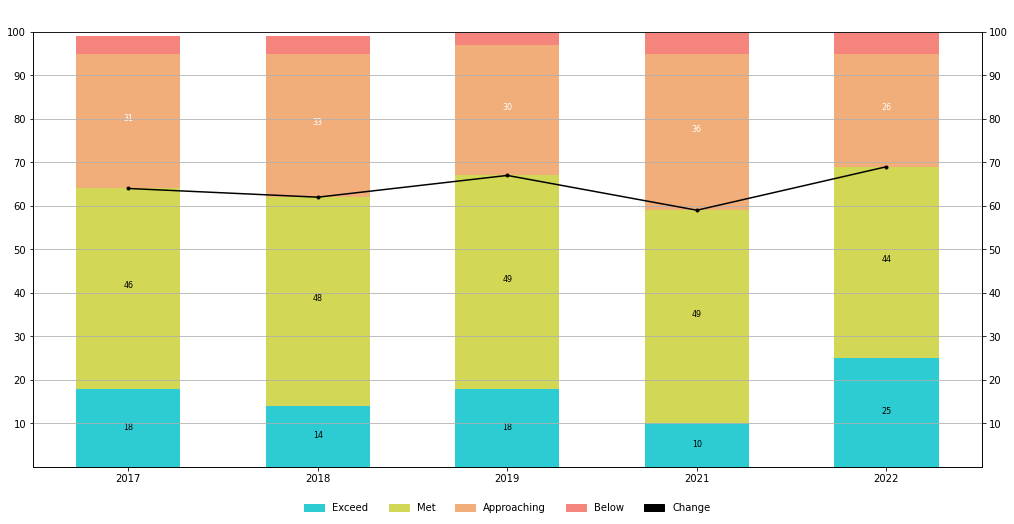

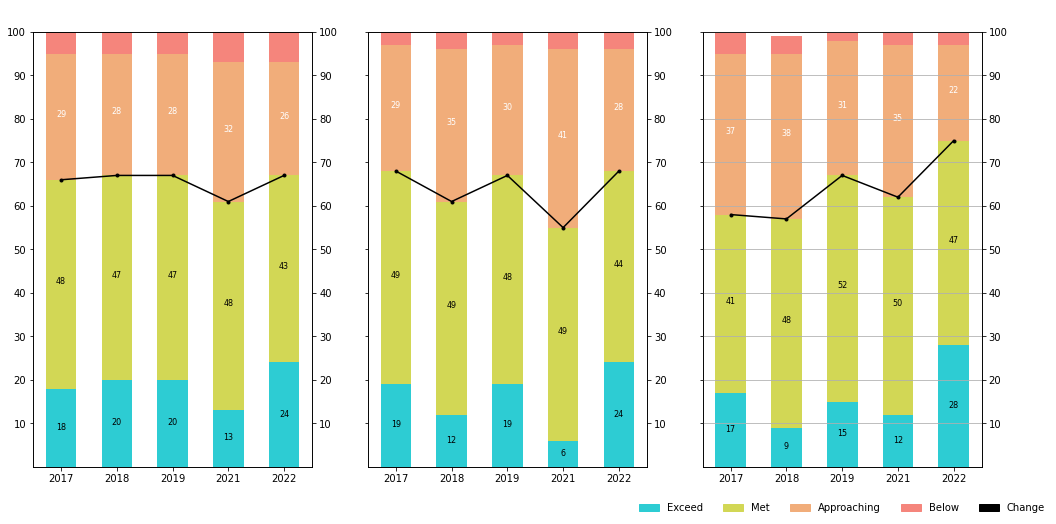

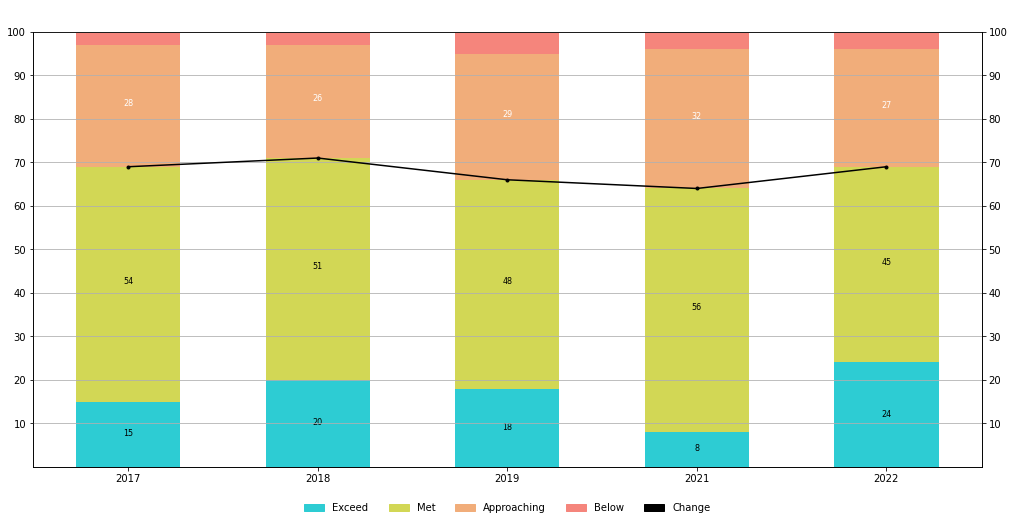

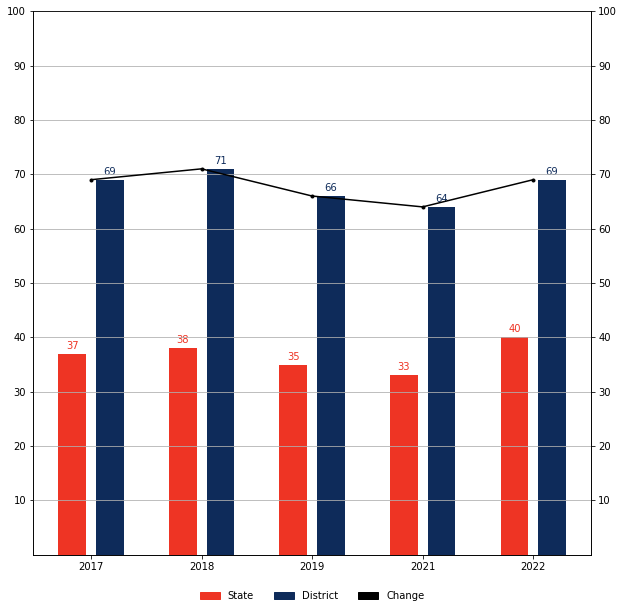

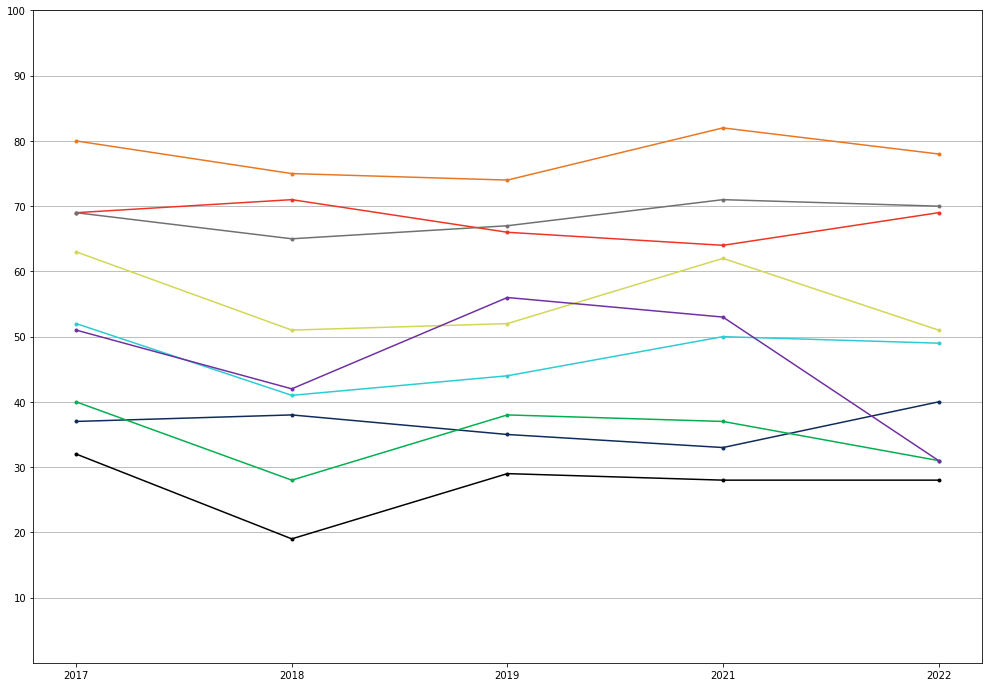

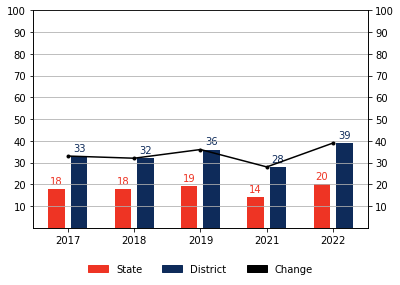

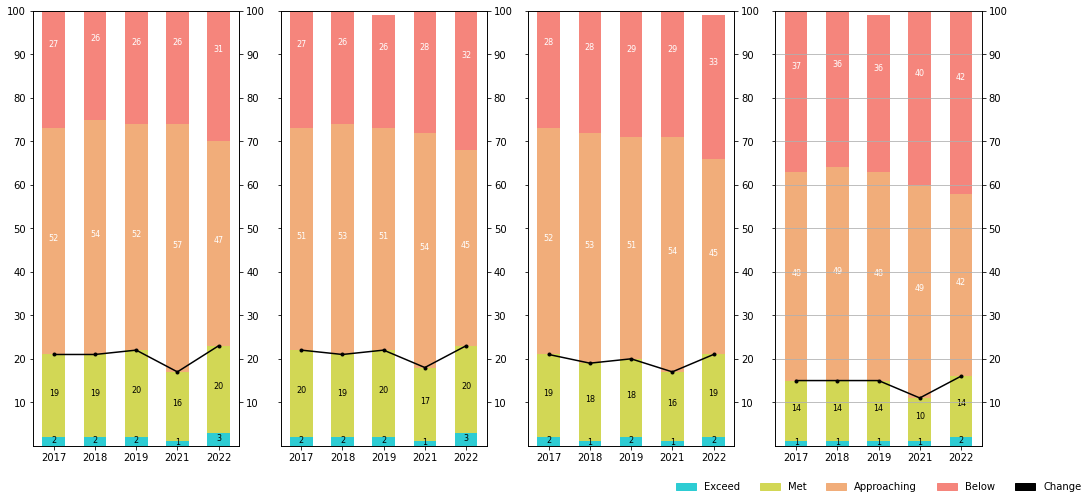

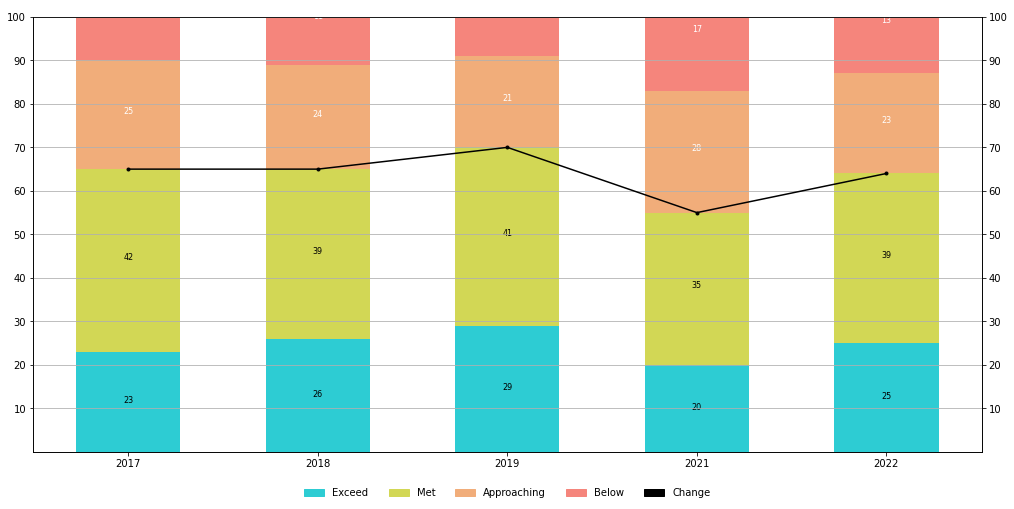

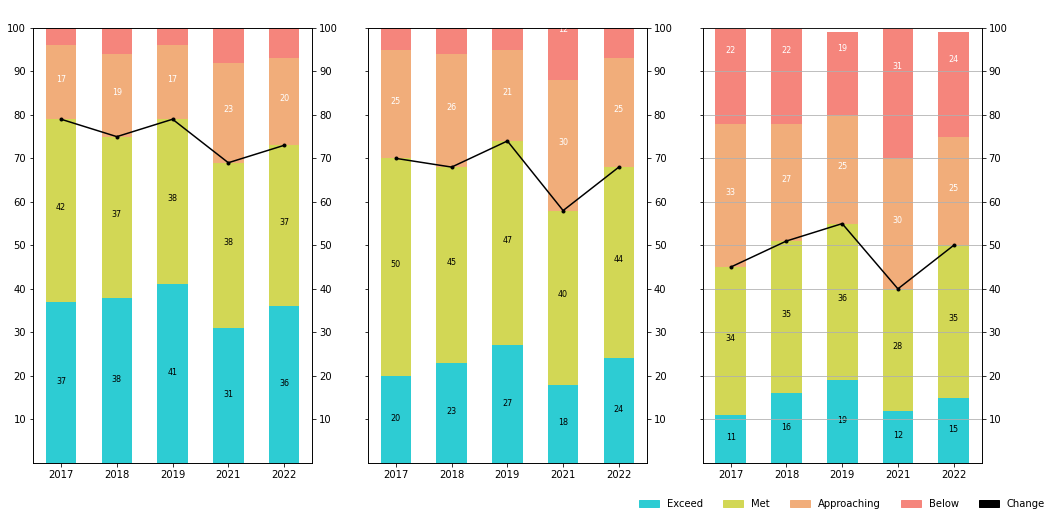

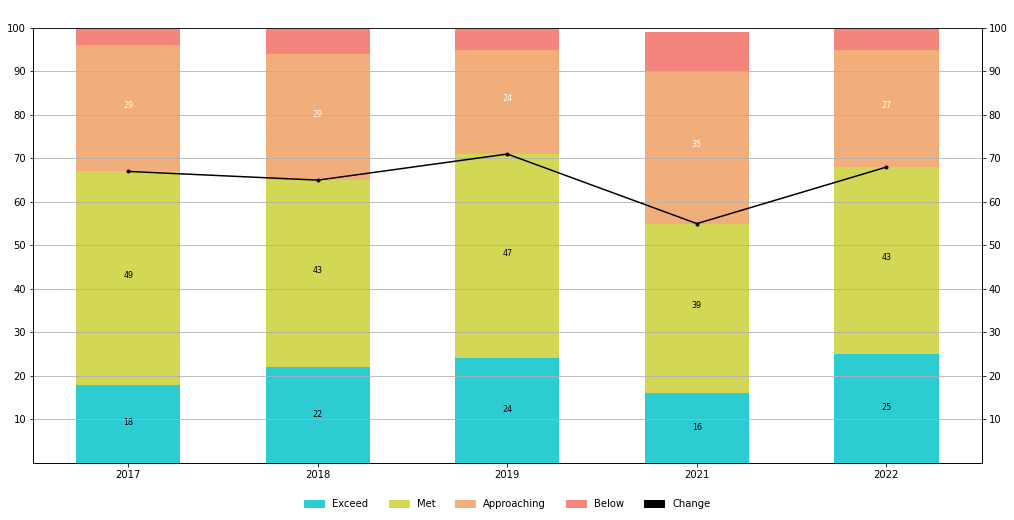

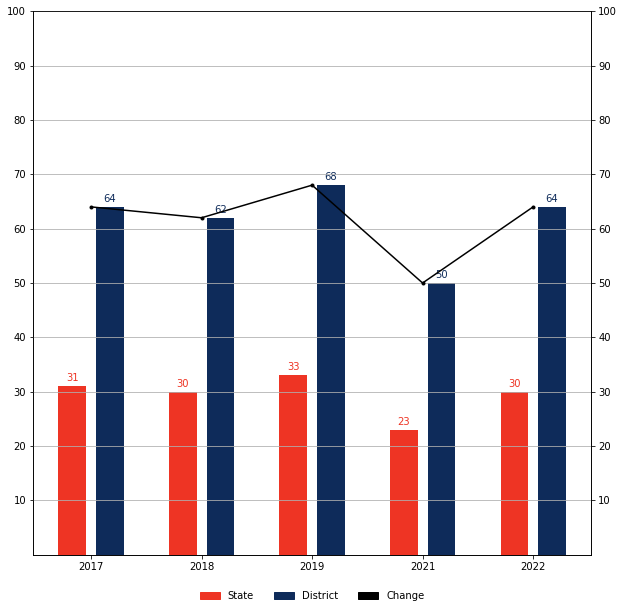

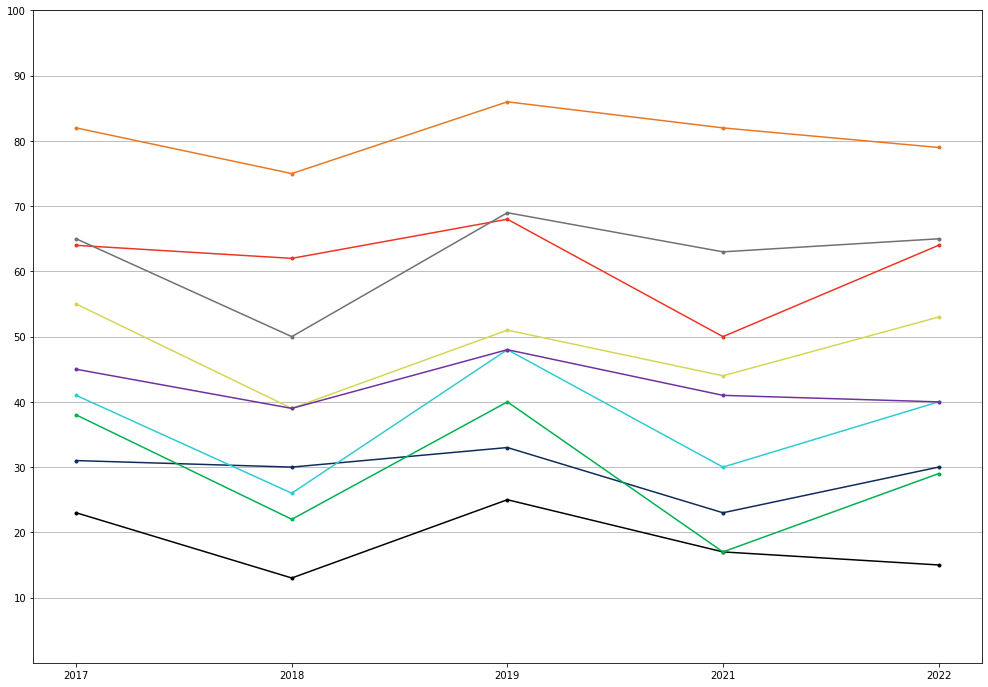

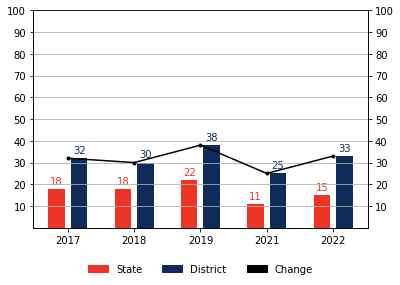

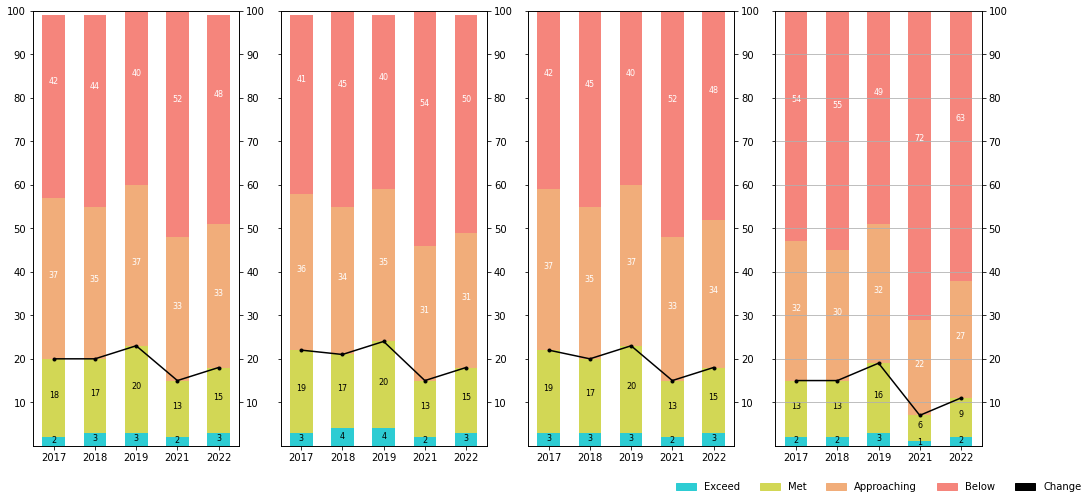

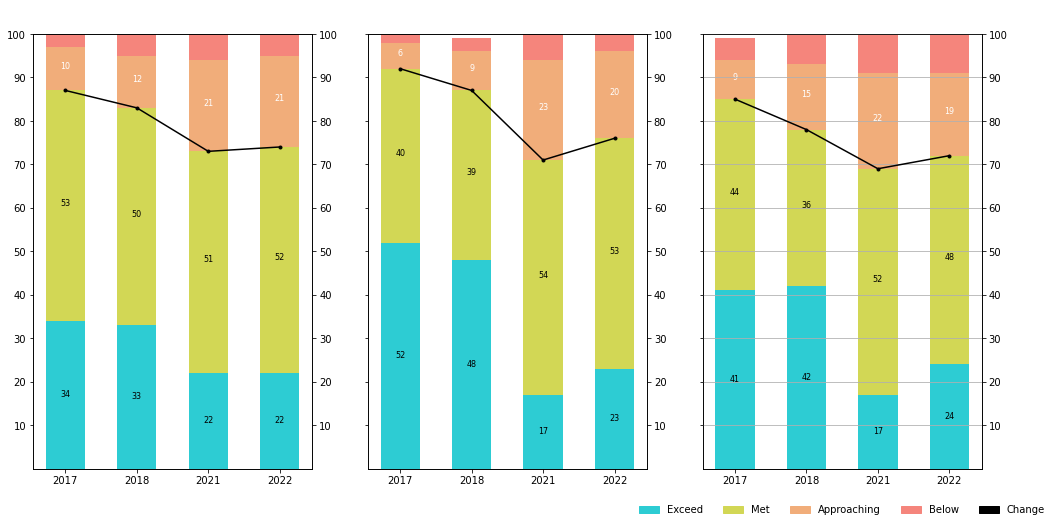

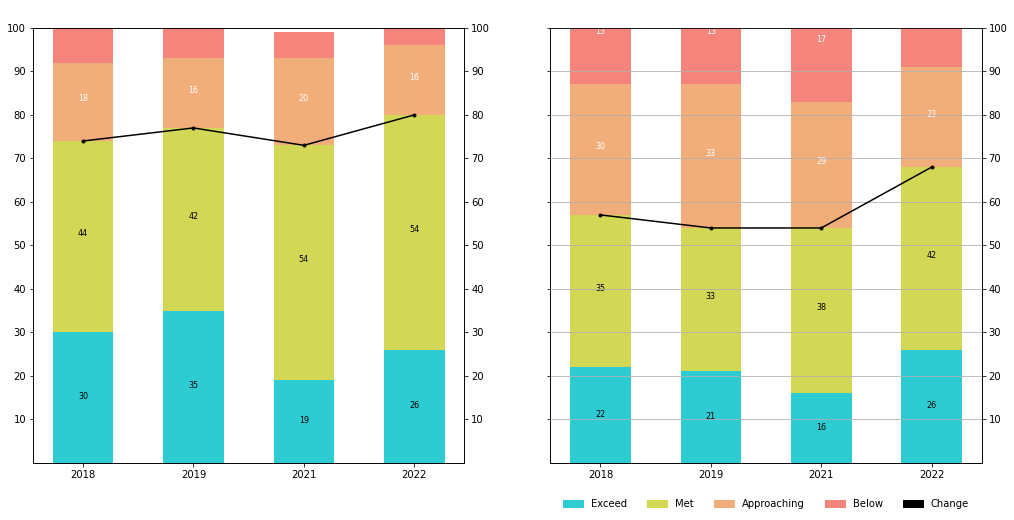

In [944]:
# ## This codeblock is for figuring out placeholder locations
ppt_template = 'TCAP District 2022_Template_Test.pptx'
ppt_temp = 'test.pptx'

prs = pptx.Presentation(ppt_template)
prs.save(ppt_temp)
prs = pptx.Presentation(ppt_temp)

df = pd.read_csv("data.csv")
df.shape

districts = getDistricts(df)

for index, district in districts.iterrows():
    for slide in SLIDES:
        workingSlide = prs.slides.add_slide(prs.slide_layouts[slide])
        workingSlide.placeholders[COUNTY_TITLE].text = district['system_name']

        if slide == ELA_ALL:
            create_All(df, district.system, workingSlide, 'ELA')
        if slide == ELA_BY_SCHOOL:
            create_By_School(df, district.system, workingSlide, 'ELA')
        if slide == ELA_SPOTLIGHT:
            create_Spotlight(df, district.system, workingSlide, '4', 'ELA')
        if slide == MATH_ALL:
            create_All(df, district.system, workingSlide, 'Math')
        if slide == MATH_BY_SCHOOL:
            create_By_School(df, district.system, workingSlide, 'Math')
        if slide == ELA_ECON:
            create_Poor(df, district.system, workingSlide, 'All Grades', 'ELA')
        if slide == MATH_ECON:
            create_Poor(df, district.system, workingSlide, 'All Grades', 'Math')
        if slide == MATH_SPOTLIGHT:
            create_MathSpotlight(df, district.system, workingSlide, '7', 'Math')
        if slide == ELA_GRADE4:
            create_Grade(df, district.system, workingSlide, '4', 'ELA', 'All Students')
        if slide == SCIENCE_BY_SCHOOL:
            create_By_School_Science(df, district.system, workingSlide, 'Science')
        if slide == SOCIAL_STUDIES_BY_SCHOOL:
            create_By_School_Social(df, district.system, workingSlide, 'Social Studies')            
        if slide == MATH_GRADE7:
            create_Grade7(df, district.system, workingSlide, '7', 'Math', 'All Students')
    
    prs.save(district['system_name'] +  ".pptx")

TypeError: createStackedBarChartPlot() missing 1 required positional argument: 'title'

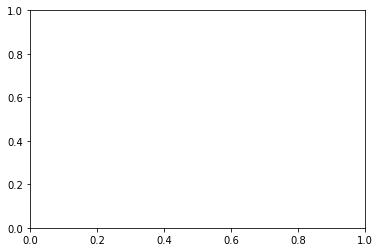

In [942]:
    fig, ax = plt.subplots(sharex='all', sharey='all')
    createStackedBarChartPlot(ax, data)

    exceed_patch = mpatches.Patch(color='#2DCCD3', label="Exceed")
    met_patch = mpatches.Patch(color='#D2D755', label="Met")
    approaching_patch = mpatches.Patch(color='#F1AD7A', label="Approaching")
    below_patch = mpatches.Patch(color='#F5857C', label="Below")
    change_patch = mpatches.Patch(color="#000000", label="Change")
    fig.set_figwidth(17)
    fig.set_figheight(8)

    plt.legend(loc="lower center", bbox_transform=fig.transFigure, ncol=5, handles=[exceed_patch, met_patch, approaching_patch, below_patch, change_patch], borderaxespad=-5, frameon=False)
    plt.grid(axis = 'y')

    image_stream = io.BytesIO()
    plt.savefig(image_stream)

In [ ]:
from pptx import Presentation
from pptx.chart.data import CategoryChartData
from pptx.enum.chart import XL_CHART_TYPE
from pptx.util import Inches
# create presentation with 1 slide ------
prs = Presentation()
slide = prs.slides.add_slide(prs.slide_layouts[5])
# define chart data ---------------------
chart_data = CategoryChartData()
chart_data.categories = [2022, 2021, 2019, 2018, 2017]
chart_data.add_series('Series 1', (19.2, 21.4, 16.7, 23, 23))
chart_data.add_series('Series 2', (19.2, 21.4, 16.7, 24, 24))
chart_data.add_series('Series 3', (19.2, 21.4, 16.7, 23 ,11))
# add chart to slide --------------------
x, y, cx, cy = Inches(2), Inches(2), Inches(6), Inches(4.5)
slide.shapes.add_chart(
XL_CHART_TYPE.COLUMN_STACKED_100, x, y, cx, cy, chart_data
)
prs.save('chart-01.pptx')

In [ ]:
    chart_data = CategoryChartData()
    chart_data.categories = years

    for index, row in data.iterrows():
        chart_data.add_series(str(index), [data.pct_exceeded_expectations, data.pct_met_expectations, data.pct_approaching, data.pct_below])

    slide.placeholders[MAIN_CHART].insert_chart(XL_CHART_TYPE.BAR_STACKED_100, chart_data)

In [ ]:

ppt_template = 'TCAP District 2022_Template_Test.pptx'
ppt_temp = 'test.pptx'

prs = pptx.Presentation(ppt_template)
prs.save(ppt_temp)
prs = pptx.Presentation(ppt_temp)

slide = prs.slides.add_slide(prs.slide_layouts[3])
for s in slide.placeholders:
    print(s.placeholder_format.idx, s.name)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['G1', 'G2', 'G3', 'G4', 'G5']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Men')
rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()